In [6]:
import numpy as np
from keras.datasets import mnist
from tqdm import tqdm
import numba
import matplotlib.pyplot as plt

In [7]:
from numba import njit, types, vectorize
from numba.extending import overload, register_jitable
from numba.core.errors import TypingError

In [8]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [9]:
train_X = train_X.reshape(-1,784).astype(np.float64)
test_X = test_X.reshape(-1,784).astype(np.float64)

In [10]:
train_X.shape

(60000, 784)

In [11]:
train_X = (train_X >= 50)*1.0
test_X = (test_X >= 50)*1.0

In [12]:
NKCs = 500
theta_KC = 32
digits = train_X.shape[0]
NAL = 784
y = np.zeros((digits,NKCs))
c = np.random.binomial(1, 0.1, NAL*NKCs).reshape(NKCs, NAL).astype(np.float64)
        
    

In [13]:
@vectorize
def _heaviside(x1, x2):
    """ vectorized implementation of the heaviside function """
    if np.isnan(x1):
        return np.nan
    elif x1 == 0:
        return x2
    elif x1 < 0:
        return 0.0
    else:
        return 1.0


@overload(np.heaviside)
def np_heaviside(x1, x2):

    def heaviside_impl(x1, x2):
        """ numba implementation of the heaviside function """
        return _heaviside(x1, x2)

    return heaviside_impl

In [14]:
@numba.jit(nopython=True)
def get_y(c, X, k):
    return np.heaviside(c.dot(X[k]) - theta_KC, 1)

In [15]:
for k in tqdm(range(digits)):
    y[k] = get_y(c, train_X, k)

100%|██████████████████████████████████| 60000/60000 [00:02<00:00, 25946.75it/s]


In [16]:
#np.save("y.npy", y)
#y = np.load("y.npy")

In [17]:
def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)


In [18]:
Y = np.zeros((9, digits))

for i in range(1,10):
    for k in range(digits):
        Y[i-1, k] = 1 if train_y[k] == i else 0

In [19]:
np.sum(train_y == 2)

5958

In [20]:
np.sum(Y[2-1])

5958.0

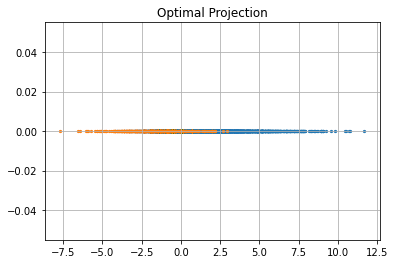

In [21]:
dgt = 2
mu_1 = np.mean(y[train_y != dgt], axis=0)
mu_2 = np.mean(y[train_y == dgt], axis=0)

Sigma1 = calculate_covariance_matrix(y[train_y != dgt])
Sigma2 = calculate_covariance_matrix(y[train_y == dgt])
Sigma = Sigma1+Sigma2

w_opt = np.linalg.pinv(Sigma)@(mu_1-mu_2)
w_opt = w_opt/np.sqrt(w_opt.T@Sigma@w_opt)
obj_opt = (w_opt.T@(mu_1-mu_2))**2

plt.scatter(w_opt.T@y[train_y != dgt].T,np.zeros((w_opt.T@y[train_y != dgt].T).shape),s=5)
plt.scatter(w_opt.T@y[train_y == dgt].T,np.zeros((w_opt.T@y[train_y == dgt].T).shape),s=5)
plt.grid()
plt.title("Optimal Projection")
plt.show()
    

In [22]:
max(np.sum(w_opt.T@y[train_y != dgt].T > 1/2 * w_opt.T@(mu_1+mu_2)) + np.sum(np.sum(w_opt.T@y[train_y == dgt].T > 1/2 * w_opt.T@(mu_1+mu_2))), np.sum(w_opt.T@y[train_y != dgt].T < 1/2 * w_opt.T@(mu_1+mu_2)) + np.sum(np.sum(w_opt.T@y[train_y == dgt].T < 1/2 * w_opt.T@(mu_1+mu_2))))/y.shape[0]*100

95.035

In [23]:
eta = 0.1; gam = 0.0001*eta; iters = 100000

In [24]:
obj = np.zeros(iters)
err = np.zeros(iters)

@numba.jit(nopython=True)
def fit(w, l, mu_1, mu_2, Sigma):
    w = w + eta*(mu_1 - mu_2 - l*Sigma@w)
    l = l + gam*((w.T@Sigma@w).item() - 1)
    
    return w, l
        
def run_offline(mu_1, mu_2, Sigma, eta, gamma, iters):
    
    w = np.random.randn(NKCs,1)/np.sqrt(NKCs)
    l = 1
    
    for i_iter in tqdm(range(iters)):
        w, l = fit(w, l, mu_1, mu_2, Sigma)
        obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
        err[i_iter] = (obj_opt - obj[i_iter])/obj_opt
        
    return w
w = run_offline(mu_1[:,None], mu_2[:,None], Sigma, eta, gam, iters)

100%|█████████████████████████████████| 100000/100000 [00:23<00:00, 4195.51it/s]


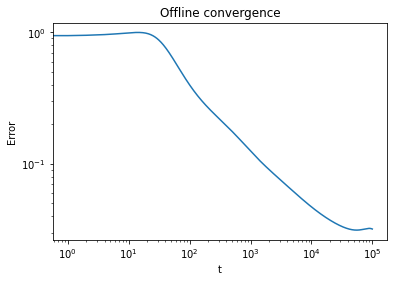

In [25]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.title("Offline convergence")
plt.show()

In [26]:
err[-1]

0.03191937616495007

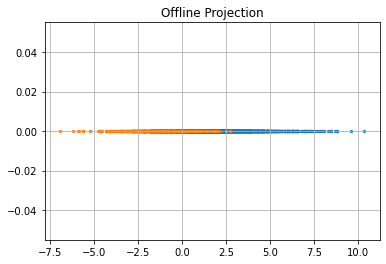

In [27]:
plt.scatter(w.T@y[train_y != dgt].T,np.zeros((w.T@y[train_y != dgt].T).shape),s=5)
plt.scatter(w.T@y[train_y == dgt].T,np.zeros((w.T@y[train_y == dgt].T).shape),s=5)
plt.grid()
plt.title("Offline Projection")
plt.show()

In [28]:
max(np.sum(w.T@y[train_y != dgt].T > 1/2 * w.T@(mu_1+mu_2)) + np.sum(np.sum(w.T@y[train_y == dgt].T > 1/2 * w.T@(mu_1+mu_2))), np.sum(w.T@y[train_y != dgt].T < 1/2 * w.T@(mu_1+mu_2)) + np.sum(np.sum(w.T@y[train_y == dgt].T < 1/2 * w.T@(mu_1+mu_2))))/y.shape[0]*100

95.00999999999999

In [43]:
e1 = 1e-4
e2 = 1e2
@numba.jit(nopython=True)
def eta(t):
    return e1#/(1+t/e2)
gam = 0.0001; epochs = 100; iters = epochs*digits
samples = digits

In [44]:
@numba.jit(nopython=True)
def fit_bio(w, l, mu, x, y, zeta, l_, t):
    wx = w.T@x
    z = wx
    
    step = eta(t)
    
    if y == 0:
        mu += (x - mu)/t
        zeta += (z-zeta)/t
        w += step*(mu - l*(z-zeta)*(x-mu))
        l += gam*step*((z-zeta)**2 - 1)
        l_ += 1
        
    else:
        w -= step*l_*x
        l_ = 1
        
        
    return w, l, mu, x, y, zeta, l_

def run_bio(X, Y):
    
    w = np.random.randn(NKCs)/np.sqrt(NKCs)
    l = 1
    zeta = 0
    l_ = 1
    
    mu = np.zeros(NKCs)

    for i_epoch in tqdm(range(epochs)):

        idx = np.random.permutation(samples)

        for i_sample in range(samples):

            i_iter = i_epoch*samples + i_sample

            t = i_iter + 1

            x = X[:,idx[i_sample]]
            y = Y[idx[i_sample]]

            w, l, mu, x, y, zeta, l_ = fit_bio(w, l, mu, x, y, zeta, l_, t)
            
            obj[i_iter] = (w.T@(mu_1[:, None]-mu_2[:, None]))**2/(w.T@Sigma@w)
            err[i_iter] = abs(obj_opt - obj[i_iter])/obj_opt
        
        #print(f'Error: {err_approx[i_iter]}')
    return w

obj = np.zeros(iters)
err = np.zeros(iters)


w = run_bio(y.T,Y[dgt-1])

100%|█████████████████████████████████████████| 100/100 [04:29<00:00,  2.69s/it]


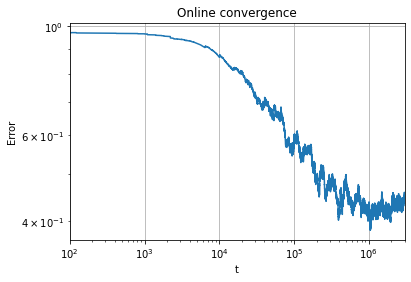

In [42]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.xlim(1e2,iters)
plt.grid()
plt.title("Online convergence")
plt.show()

In [115]:
err[-1]

0.31656543259391073

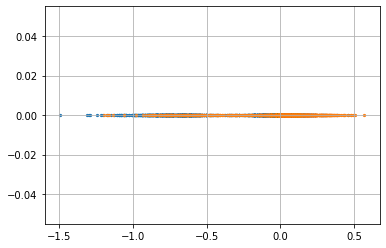

In [116]:
plt.scatter(w.T@y[train_y != 0].T,np.zeros((w.T@y[train_y != 0].T).shape),s=5)
plt.scatter(w.T@y[train_y == 0].T,np.zeros((w.T@y[train_y == 0].T).shape),s=5)
plt.grid()
plt.show()

In [117]:
max(np.sum(w.T@y[train_y != dgt].T > 1/2 * w.T@(mu_1+mu_2)) + np.sum(np.sum(w.T@y[train_y == dgt].T > 1/2 * w.T@(mu_1+mu_2))), np.sum(w.T@y[train_y != dgt].T < 1/2 * w.T@(mu_1+mu_2)) + np.sum(np.sum(w.T@y[train_y == dgt].T < 1/2 * w.T@(mu_1+mu_2))))/y.shape[0]*100

96.45333333333333

In [118]:
np.mean(np.sum(y, axis=1)/1000)

0.0005461333333333333